# Fracitonal Cover <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls_usgs_fc_scene](https://explorer.digitalearth.africa/ls_usgs_fc_scene), 
[ls_usgs_wofs_scene](https://explorer.digitalearth.africa/ls_usgs_wofs_scene),
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a),
* **Prerequisites:** For more details and better understanding of the input datasets and method used, see the notebooks covering [Sentinel-2](../Datasets/Sentinel_2.ipynb), [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) and [Geomedian](../Frequently_used_code/Generating_geomedian_composites.ipynb).


### Background

Fractional Cover (FC) product provides estimates of the proportions of green vegetation, non-green vegetation (including deciduous trees during autumn, dry grass, etc.), and bare soils for every Landsat or Sentinel-2 pixel.

This product supports a range of environemental and agricultural applications, including soil erosion monitoring, land surface process modelling, land management and vegetation studies. The information can be used by policy agencies, natural and agricultural land resource managers, and scientists to monitor land conditions over large areas over long time periods.

The algorithm is developed by the Joint Remote Sensing Research Program (JRSRP) and is described in Scarth et al. (2010). Field data collected across Australia have been used to calibrate and validate the unmixing model.

More information on the product can be found [here](http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Seasonal+Fractional+Cover).

**Reference**

Scarth, P, Roder, A and Schmidt, M 2010, 'Tracking grazing pressure and climate interaction - the role of Landsat fractional cover in time series analysis', Proceedings of the 15th Australasian Remote Sensing & Photogrammetry Conference (ARSPC), 13-17 September, Alice Springs, Australia. Alice Springs, NT.



## Description

This notebook will cover following topics:

1. Loading, masking and visualizing pre-generated FC data.
2. Calculating FC from Sentinel-2 surface reflectance and generating monthly composites.

***

## Getting started

To use this notebook, run the cells in this section, under "Load packages", "Connect to the datacube" and "Analysis parameters".

The two sections below, "Loading, masking and visualizing pre-generated FC data" and "Calculating FC from Sentinel-2 surface reflectance" can be run independently.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import xarray as xr

import datacube
from datacube.utils import masking
from fc.fractional_cover import compute_fractions

import sys
sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_datahandling import calc_geomedian


/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [2]:
dc = datacube.Datacube(app='fractional_cover')

### Analysis parameters

This section defines the analysis parameters, including 

* center lat/lon and analysis window size for the area of interest
* time period to be investigated
* projection for loading data; output resolution is not defined so different resolutions can be used for Landsat and Sentinel-2
* minimum fraction of good data required for a (FC or surface reflectance) scene to be kept

The default location is an area along Dawa river on the Ethiopia-Kenya border.

Default resolution, spatial and temporal extents are chosen to limit the time required for calculating FC from Sentinel-2 surface reflectance.

In [3]:
lat, lon = 3.96, 41.64
buffer_lat, buffer_lon = 0.03, 0.04

query = {
    'time': ('2017-01', '2017-12'),
    'x': (lon - buffer_lon, lon + buffer_lon),
    'y': (lat + buffer_lat, lat - buffer_lat),
    'output_crs': 'epsg:6933',
}

min_gooddata = 0.9

## Loading, masking and visualizing pre-generated FC data

FC have been calculated from Landsat Collection 1 surface refletance, at 30 m spatial resolution.

FC generated from different Landsat satellites (5, 7 and 8) are combined into one product. Setting a high `min_goodata` threshold above will exclude data from Landsat 7 SLC-off. 

In [4]:
# load all available fc data
ls_fc = dc.load(product = 'ls_usgs_fc_scene', resolution=(-30, 30), **query)

In [5]:
# drop invalid scenes
ls_fc = ls_fc.where(ls_fc>=0).dropna('time', how='all')

### Masking FC with Water Observations from Space Feature Layer

The unmixing algorithm breaks down when water or cloud is present.
The Water Observations Feature Layer can be used to exclude these problematic pixels.

For more information on bitmasking, see the [Applying WOfS bitmasking notebook](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb).

> If there's no matching WOFL product available, cloud mask from the input Landsat data can be used.

Additional filtering can be done by requiring sum of the 3 fractions to be close to 100 percent and/or the unxming error to be small.
However, these constraints alone are not sufficient to exclude all problematic FC results. 

In [6]:
# select WOFL from the same dates
wofl = dc.load(product='ls_usgs_wofs_scene', resolution=(-30, 30), **query).sel(time=ls_fc.time)

# make a clear and dry pixel mask
clear_and_dry = masking.make_mask(wofl, dry=True).water

In [7]:
# only keep mostly clear scenes
good_slice = clear_and_dry.mean(['x','y']) > min_gooddata

In [8]:
fc_clear = ls_fc.where(clear_and_dry).isel(time=good_slice)

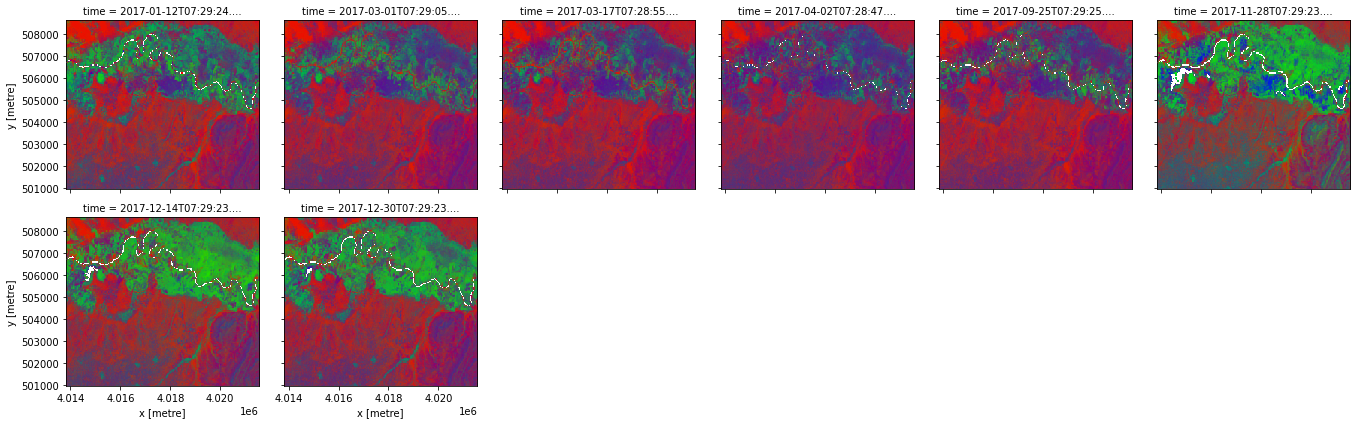

In [9]:
fc_clear[['BS','PV','NPV']].to_array().plot.imshow(col='time', col_wrap=6);

## Calculating FC from Sentinel-2 surface reflectance

FC can be generated on-the-fly from surface reflectance data.

In this example, surface reflectance in Sentinel-2 bands `green`(B03), `red`(B04), `nir`(B08), `swir_1`(B11) and `swir_2`(B12) are used, assuming they are equivalent to similarly named Landsat spectral bands. 

In [10]:
# Define spectral bands to use
bands = ['green','red','nir','swir_1','swir_2']

### Load Sentinel-2 surface reflectance

Use the provided scene classification layer to mask out water, snow, cloud and cloud_shadow. 

> The `cloud_cover` parameter is used to reject mostly cloudy input granules.
> This helps to reduce noisy results from missed clouds.
> This `cloud_cover` is calculated over the entire Sentinel-2 granule, not for the area of interest in this analysis.

In [11]:
# load clear sentinel-2 data at 20 m spatial resolution

s2 = load_ard(dc=dc,
              products=['s2_l2a'],
              measurements=bands,
              pq_categories_s2=['vegetation', 'bare soils', 'unclassified', 'dark area pixels'],
              min_gooddata=min_gooddata,
              dask_chunks={},
              cloud_cover = (0, 40),
              resolution = (-20, 20),
              **query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 25 out of 33 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 25 time steps as a dask array


In [12]:
# Convert s2 data into a dataarray with spectral bands as its first dimension
# if dask is used, rechunk to load all spectral bands at once

input_data = s2[bands].to_array(dim='band').chunk({'band':-1})

### Apply spectral unmixing

This calculation takes about 10 minutes for the default parameters.

In [13]:
# define function to compute fractional cover and return a datarray

def compute_fc(input_da, regression_coefficients = None):
    """
    Compute fractional cover from an input data array.
    
    Parameters
    ---------- 
    input_da: xr.DataArray
        A 3-dimensional dataArray with the first dimension being spectral bands
    
    regression_coefficients: dict, optional
        A dictionary containing linear regression coefficients to transform the input spectral bands
        e.g. {'green':[31, 1.0582],
              'red':[64, 0.9871],
              'nir':[120, 1.0187],
              'swir1':[79, 0.9528],
              'swir2':[-42, 0.9688]}

    Returns
    -------
    A 3-dimensional xr.DataArray with the first dimension containing the FC components.  
    """
    # prepare input data
    is_valid_array= (input_da >0).all(dim=input_da.dims[0])
    input_da = input_da.where(is_valid_array, 0)
    # define output coordinates
    output_coords = {'variable': ['PV', 'NPV', 'BS', 'UE']}
    output_dims = ['variable']
    for dim in input_da.dims[1:]:
        output_coords[dim] = input_da.coords[dim]
        output_dims.append(dim)
    # calculate FC
    output = compute_fractions(input_da, regression_coefficients = regression_coefficients)
    # nodata value is -1
    return xr.DataArray(output, coords=output_coords, dims=output_dims).where(is_valid_array, -1)

In [14]:
%%time 

output = input_data.groupby('time').apply(compute_fc).compute()

CPU times: user 10min 46s, sys: 4min 28s, total: 15min 15s
Wall time: 8min 16s


In [15]:
# convert to dataset to be compatible with pre-generated data
s2_fc = output.to_dataset(dim='variable')

### Visualize Sentinel-2 based FC at monthly interval

Sentinel-2 has frequent temporal coverage, however, the scene classification fails to identify some clouds.
The FC results can be aggreated monthly to reduce the impact of clouds.

> Monthly composites are generated using the `geomedian` method, which maintains the relationship between the BS, PV and NPV components.
> For more details of this method, see the [Geomedian notebook](../Frequently_used_code/Generating_geomedian_composites.ipynb)

In [16]:
# generate monthly geomedian
s2_monthly_gm = s2_fc.where(s2_fc>=0)[['BS','PV','NPV']].resample(time='M').apply(calc_geomedian, axis='time')

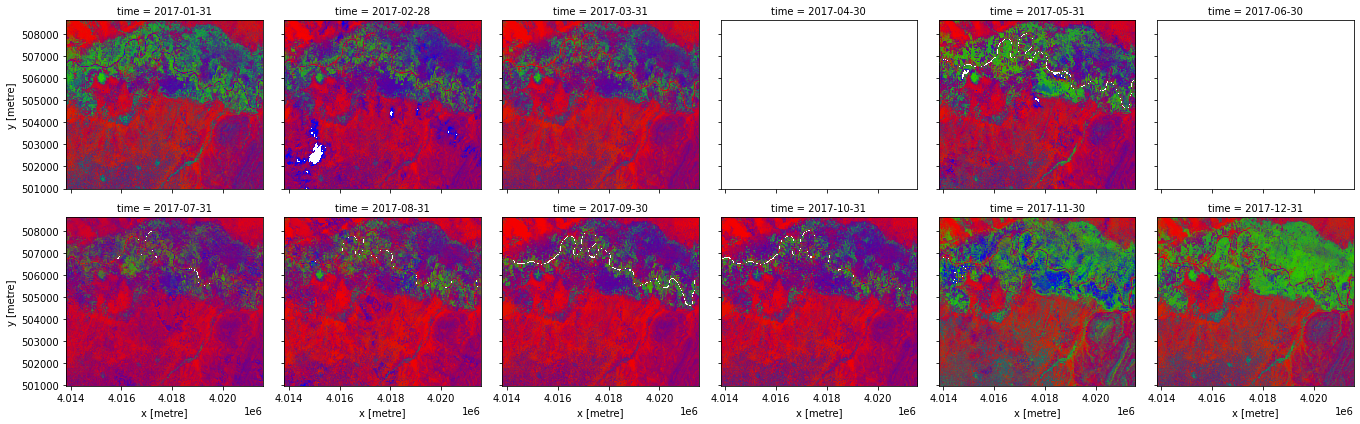

In [17]:
# check results
s2_monthly_gm[['BS','PV','NPV']].to_array().plot.imshow(col='time',col_wrap=6);

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** July 2020

**Compatible datacube version:** 

In [18]:
print(datacube.__version__)

1.8.0


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)